# Bibliotecas e funções auxiliares

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import unidecode

from collections import defaultdict
from itertools import pairwise
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from tqdm.auto import tqdm

## Constantes e funções auxiliares

In [2]:
NULL_STRING = '#NULO#'
MAX_CAT_COUNT = 4

In [3]:
def get_basic_clean_docs(df_docs):

    df = df_docs.copy()
    
    # limpeza inicial dos documentos
    # lowercase e remoção de acentos
    # extração e contatgem dos tokens
    clean_tokens = []
    tokens_freq = FreqDist()
    
    for doc in tqdm(df.loc[:,'Nome'].to_list()):
        doc = unidecode.unidecode(doc.lower())
        tokens = word_tokenize(doc)
        clean_tokens.append(tokens)
        tokens_freq.update(tokens)
    
    clean_docs = [' '.join(tokens) for tokens in clean_tokens]
    df['clean_docs'] = clean_docs
    df['clean_tokens'] = clean_tokens
    columns_to_keep = ['clean_docs', 'clean_tokens', 'cat_0']
    df = df[columns_to_keep]
    
    return df, tokens_freq

In [4]:
def get_clean_docs(df_docs):

    df = df_docs.copy()
    
    # limpeza inicial dos documentos
    # lowercase e remoção de acentos
    # extração e contatgem dos tokens
    clean_tokens = []
    tokens_freq = FreqDist()

    stop_words = stopwords.words('portuguese')
    
    for doc in tqdm(df.loc[:,'Nome'].to_list()):
        doc = unidecode.unidecode(doc.lower())
        tokens = [token for token in word_tokenize(doc) if token not in stop_words and token not in punctuation]
        clean_tokens.append(tokens)
        tokens_freq.update(tokens)
    
    clean_docs = [' '.join(tokens) for tokens in clean_tokens]
    df['clean_docs'] = clean_docs
    df['clean_tokens'] = clean_tokens
    columns_to_keep = ['clean_docs', 'clean_tokens', 'cat_0']
    df = df[columns_to_keep]
    return df, tokens_freq

In [5]:
def plot_tokens_freq(tokens_freq, bins = [1,2,3,4,5,np.inf]):
    
    tokens_count = [count for token, count in tokens_freq.most_common()]
    tokens_hist,_ = np.histogram(tokens_count,bins=bins)
    
    x_labels = []
    for start,stop in pairwise(bins):
        if stop==bins[-1]:
            x_labels.append(f'{start} ou mais')
        elif stop==start+1:
            x_labels.append(f'{start}')
        else:
            x_labels.append(f'{start} a {stop-1}')
    
    bar_labels = [f'{height:,d}'.replace(',','.') for height in tokens_hist]
    
    fig, ax = plt.subplots()
    
    for x,height in zip(x_labels,tokens_hist):
        p = ax.bar(x,height)
        ax.bar_label(p, label_type='center')
    
    ax.tick_params(bottom=False, left=False,
                   labelbottom=True, labelleft=False)
    
    # remove the frame of the chart
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_title('Quantidade de tokens por frequência')
    ax.set_xlabel('Frequência do token')
    ax.set_ylabel('Quantidade de tokens')
    
    plt.show()

In [6]:
def plot_doc_vectors(df_clean_docs, top_cats=False, s=5):

    docs = df_clean_docs['clean_docs']
    targets = df_clean_docs['cat_0']
    
    count_vectorizer = CountVectorizer()
    docs_count_matrix = count_vectorizer.fit_transform(docs)
    
    count_vectorizer_2 = CountVectorizer(min_df=2)
    docs_count_matrix_2 = count_vectorizer_2.fit_transform(docs)
    
    count_vectorizer_5 = CountVectorizer(min_df=5)
    docs_count_matrix_5 = count_vectorizer_5.fit_transform(docs)

    tfidf_vectorizer = TfidfVectorizer()
    docs_tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
    
    tfidf_vectorizer_2 = TfidfVectorizer(min_df=2)
    docs_tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(docs)
    
    tfidf_vectorizer_5 = TfidfVectorizer(min_df=5)
    docs_tfidf_matrix_5 = tfidf_vectorizer_5.fit_transform(docs)
    
    pca = TruncatedSVD(n_components=2)
    
    pca_count_docs = pca.fit_transform(docs_count_matrix)
    pca_count_docs_2 = pca.fit_transform(docs_count_matrix_2)
    pca_count_docs_5 = pca.fit_transform(docs_count_matrix_5)
    
    pca_tfidf_docs = pca.fit_transform(docs_tfidf_matrix)
    pca_tfidf_docs_2 = pca.fit_transform(docs_tfidf_matrix_2)
    pca_tfidf_docs_5 = pca.fit_transform(docs_tfidf_matrix_5)
    
    count_scatter_x = pca_count_docs[:, 0] # first principle component
    count_scatter_y = pca_count_docs[:, 1] # second principle component
    
    count_scatter_x_2 = pca_count_docs_2[:, 0] # first principle component
    count_scatter_y_2 = pca_count_docs_2[:, 1] # second principle component
    
    count_scatter_x_5 = pca_count_docs_5[:, 0] # first principle component
    count_scatter_y_5 = pca_count_docs_5[:, 1] # second principle component

    tfidf_scatter_x = pca_tfidf_docs[:, 0] # first principle component
    tfidf_scatter_y = pca_tfidf_docs[:, 1] # second principle component
    
    tfidf_scatter_x_2 = pca_tfidf_docs_2[:, 0] # first principle component
    tfidf_scatter_y_2 = pca_tfidf_docs_2[:, 1] # second principle component
    
    tfidf_scatter_x_5 = pca_tfidf_docs_5[:, 0] # first principle component
    tfidf_scatter_y_5 = pca_tfidf_docs_5[:, 1] # second principle component
    
    fig, axs = plt.subplots(2,3,figsize=(15,10))
    
    # group by clusters and scatter plot every cluster
    # with a colour and a label
    if not top_cats:
        for group in np.unique(targets):
            ix = np.where(targets == group)
            
            axs[0][0].scatter(count_scatter_x[ix], count_scatter_y[ix], label=group, s=s)
            axs[0][1].scatter(count_scatter_x_2[ix], count_scatter_y_2[ix], label=group, s=s)
            axs[0][2].scatter(count_scatter_x_5[ix], count_scatter_y_5[ix], label=group, s=s)
            
            axs[1][0].scatter(tfidf_scatter_x[ix], tfidf_scatter_y[ix], label=group, s=s)
            axs[1][1].scatter(tfidf_scatter_x_2[ix], tfidf_scatter_y_2[ix], label=group, s=s)
            axs[1][2].scatter(tfidf_scatter_x_5[ix], tfidf_scatter_y_5[ix], label=group, s=s)
    else:
        ix_top = np.where(targets == 1)
        ix_other = np.where(targets > 1)
        for ix,group in zip([ix_top, ix_other],['top','other']):
            
            axs[0][0].scatter(count_scatter_x[ix], count_scatter_y[ix], label=group, s=s)
            axs[0][1].scatter(count_scatter_x_2[ix], count_scatter_y_2[ix], label=group, s=s)
            axs[0][2].scatter(count_scatter_x_5[ix], count_scatter_y_5[ix], label=group, s=s)
            
            axs[1][0].scatter(tfidf_scatter_x[ix], tfidf_scatter_y[ix], label=group, s=s)
            axs[1][1].scatter(tfidf_scatter_x_2[ix], tfidf_scatter_y_2[ix], label=group, s=s)
            axs[1][2].scatter(tfidf_scatter_x_5[ix], tfidf_scatter_y_5[ix], label=group, s=s)
    
    axs[0][0].set_title('CountVectorizer')
    axs[0][1].set_title('CountVectorizer (min 2)')
    axs[0][2].set_title('CountVectorizer (min 5)')
    
    axs[1][0].set_title('TfidfVectorizer')
    axs[1][1].set_title('TfidfVectorizer (min 2)')
    axs[1][2].set_title('TfidfVectorizer (min 5)')
    
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # plt.xlabel("PCA 0")
    # plt.ylabel("PCA 1")
    plt.show()

# Carga e prepação dos dados

## Carga dos arquivos e separação dos dataframes

In [7]:
file_amazon = '../datasets/amazon.parquet.gzip'
df_amazon = pd.read_parquet(file_amazon).reset_index(drop=True)
df_amazon['cat_0'] = df_amazon['cat_0'].fillna(NULL_STRING)
df_amazon['Nome'] = df_amazon['Nome'].fillna(NULL_STRING)
df_amazon.head()

,Link,Palavra_Chave,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,Marca,Modelo,...,Vendedor,Data_Inclusão,Ativo,Descrição_Principal,Link_Vendedor,Preço_Original,Qtd_disponível,Qtd_vendidos,Desconto,Estado
0,https://www.amazon.com.br/Especiais-Cinematic-...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Filtros,<NA>,<NA>,Odorkle,<NA>,...,Lantacy,2024-03-06 01:49:12,True,Modelo aplicável: este filtro de listras azuis...,https://www.amazon.com.br/gp/help/seller/at-a-...,<NA>,<NA>,<NA>,<NA>,<NA>
1,https://www.amazon.com.br/Motores-Escova-Conju...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,<NA>,<NA>,Airshi,Airshimowq96xigy-11,...,Aiterwu,2024-03-06 01:49:00,True,Fonte de alimentação: este motor sem escova de...,https://www.amazon.com.br/gp/help/seller/at-a-...,<NA>,<NA>,<NA>,<NA>,<NA>
2,https://www.amazon.com.br/Armazenamento-Protet...,drone,Brinquedos e Jogos,Brinquedos de Controle Remoto,<NA>,<NA>,<NA>,<NA>,Zhjvihx,<NA>,...,Zhjvihx-US,2024-03-06 01:48:46,True,Válvula de Alívio de Pressão: Equipada com vál...,https://www.amazon.com.br/gp/help/seller/at-a-...,<NA>,<NA>,<NA>,<NA>,<NA>
3,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,<NA>,<NA>,Equss,EQUSS,...,Dengzhoushilianzhouqichepeijianshanghang,2024-03-06 01:48:26,True,"[Super Grip] - Design criativo, quatro suporte...",https://www.amazon.com.br/gp/help/seller/at-a-...,<NA>,<NA>,<NA>,<NA>,<NA>
4,https://www.amazon.com.br/remote-control-brush...,drone,Eletrônicos e Tecnologia,Câmeras e Foto,Acessórios,Acessórios para Drones,<NA>,<NA>,Uxsiya,Uxsiyay49ekqxi1t,...,Mseinope-US,2024-03-06 01:48:14,True,<NA>,https://www.amazon.com.br/gp/help/seller/at-a-...,<NA>,<NA>,<NA>,<NA>,<NA>


In [8]:
columns_to_keep = ['cat_0', 'Nome']
df_categories = df_amazon[columns_to_keep].groupby('cat_0',as_index=False).count().sort_values(by='Nome',ascending=False)
df_categories = df_categories.reset_index(drop=True)
df_categories.columns = ['cat_0', 'count']
df_categories['cum_sum'] = df_categories['count'].cumsum()
df_categories['cum_part'] = df_categories['cum_sum'].apply(lambda x: x/df_categories['count'].sum()*100)
df_categories

,cat_0,count,cum_sum,cum_part
0,#NULO#,100406,100406,66.151454
1,Eletrônicos e Tecnologia,39062,139468,91.887049
2,Computadores e Informática,11194,150662,99.262100
3,Games e Consoles,253,150915,99.428786
4,Casa,125,151040,99.511141
5,Moda,124,151164,99.592837
6,Ferramentas e Materiais de Construção,88,151252,99.650815
7,Brinquedos e Jogos,76,151328,99.700887
8,Automotivo,65,151393,99.743711
9,Instrumentos Musicais,62,151455,99.784559


In [9]:
map_cat_0 = {k:(v if v < MAX_CAT_COUNT else MAX_CAT_COUNT) for v,k in df_categories.cat_0.to_dict().items()}
map_cat_0

{'#NULO#': 0,
 'Eletrônicos e Tecnologia': 1,
 'Computadores e Informática': 2,
 'Games e Consoles': 3,
 'Casa': 4,
 'Moda': 4,
 'Ferramentas e Materiais de Construção': 4,
 'Brinquedos e Jogos': 4,
 'Automotivo': 4,
 'Instrumentos Musicais': 4,
 'Papelaria e Escritório': 4,
 'Beleza': 4,
 'Esporte, Aventura e Lazer': 4,
 'Eletrônicos para Carros e Veículos': 4,
 'Acessórios Eletrônicos para Carros': 4,
 'Jardim e Piscina': 4,
 'DVD e Blu-ray': 4,
 'Produtos Industriais e Científicos': 4,
 'Livros': 4,
 'CD e Vinil': 4,
 'Cozinha': 4,
 'Loja Kindle': 4,
 'Saúde e Bem-Estar': 4,
 'Bebês': 4,
 'Proteção e Segurança': 4,
 'Pet Shop': 4,
 'Dispositivos Amazon e Acessórios': 4,
 'Peças para Automóveis': 4,
 'Alimentos e Bebidas': 4,
 'Produtos Laboratoriais e Científicos': 4,
 'Equipamentos para Esportes ao Ar Livre e de Aventura': 4}

In [10]:
df_docs = df_amazon[['Nome','cat_0']]
df_docs.loc[:,'cat_0'] = df_docs['cat_0'].map(map_cat_0)
df_docs_not_null = df_docs[df_docs['cat_0']>0]
df_docs = df_docs.reset_index(drop=True)
df_docs_not_null = df_docs_not_null.reset_index(drop=True)
df_docs

,Nome,cat_0
0,Filtro de Lente de Efeitos Especiais Blue Stre...,1
1,"Motores Sem Escova, 4 Conjuntos de Motores Sem...",1
2,"Bolsa de Armazenamento Protetora para Drone, C...",4
3,EQUSS Para DUCATI DL650 DL1000 V-strom DL 650 ...,1
4,"remote control car brushless motor servo kit,r...",1
...,...,...
151777,"Mini drone de bolso, HD Folding Fotografia Aér...",1
151778,"YITRE Mini Carregador Portátil, 2 Em 1 Carrega...",1
151779,"Kit de reforço de sinal,Kit de reforço de sina...",2
151780,Hosioe LS-XT6 RC Drone Mini Drone 6 eixos Gyro...,1


In [11]:
for x in df_docs.sample(5)['Nome']:
    print(x,'\n')

Xiaomimijia AR Impresora 300dpi Portátil Foto Mini Bolsillo Con DIY Compartir 500mAh Imagen Impresora Bolsillo Impresora Trabajar Con Mijia 

Transmissor Bluetooth, 3 peças KN320 adaptador Bluetooth 5.0 transmissor/receptor de áudio sem fio ampla compatibilidade para computadores laptops sistemas estéreo domésticos fones de ouvido 

RC Aircraft Motor, 2Pcs Aluminum Alloy Brushless Motor Fine Workmanship for Four Axes Aerial Photography Machine 

Adaptador de rede sem fio USB 3.0 mini banda dupla, adaptador USB WiFi 1200 m 2.4G + 5G Dual Band Gigabit Network Card para PCLaptop Desktop, para Windows Vista XP 7 8 10 

Sutinna Fones de ouvido Bluetooth sem fio, True Wireless Bluetooth 5.0 Conectam automaticamente fones de ouvido esportivos com o verdadeiro alto-falante circular de cobre 



In [12]:
docs = [word_tokenize(doc) for doc in tqdm(df_docs['Nome'])]
docs_len = [len(doc) for doc in tqdm(docs)]

  0%|          | 0/151782 [00:00<?, ?it/s]

  0%|          | 0/151782 [00:00<?, ?it/s]

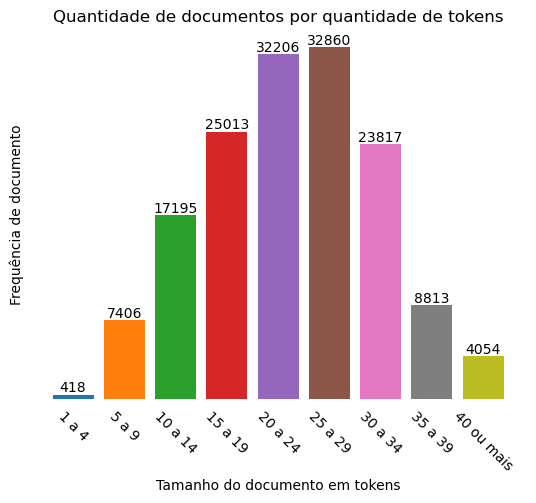

In [13]:
bins = [1,5,10,15,20,25,30,35,40,150]

heights,bins = np.histogram(docs_len,bins=bins)
  
x_labels = []
for start,stop in pairwise(bins):
    if stop==bins[-1]:
        x_labels.append(f'{start} ou mais')
    elif stop==start+1:
        x_labels.append(f'{start}')
    else:
        x_labels.append(f'{start} a {stop-1}')
    
bar_labels = [f'{height:,d}'.replace(',','.') for height in heights]
    
fig, ax = plt.subplots()
    
for x,height in zip(x_labels,heights):
    p = ax.bar(x,height)
    ax.bar_label(p, label_type='edge')
    
ax.tick_params(bottom=False, left=False,labelbottom=True, labelleft=False,labelrotation = -45)

# remove the frame of the chart
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_title('Quantidade de documentos por quantidade de tokens')
ax.set_xlabel('Tamanho do documento em tokens')
ax.set_ylabel('Frequência de documento')

plt.show()

# Visualização

## Todos os anúncios

In [14]:
df_basic_clean_docs, tokens_freq_basic_clean_docs = get_basic_clean_docs(df_docs)
df_basic_clean_docs

  0%|          | 0/151782 [00:00<?, ?it/s]

,clean_docs,clean_tokens,cat_0
0,filtro de lente de efeitos especiais blue stre...,"[filtro, de, lente, de, efeitos, especiais, bl...",1
1,"motores sem escova , 4 conjuntos de motores se...","[motores, sem, escova, ,, 4, conjuntos, de, mo...",1
2,"bolsa de armazenamento protetora para drone , ...","[bolsa, de, armazenamento, protetora, para, dr...",4
3,equss para ducati dl650 dl1000 v-strom dl 650 ...,"[equss, para, ducati, dl650, dl1000, v-strom, ...",1
4,"remote control car brushless motor servo kit ,...","[remote, control, car, brushless, motor, servo...",1
...,...,...,...
151777,"mini drone de bolso , hd folding fotografia ae...","[mini, drone, de, bolso, ,, hd, folding, fotog...",1
151778,"yitre mini carregador portatil , 2 em 1 carreg...","[yitre, mini, carregador, portatil, ,, 2, em, ...",1
151779,"kit de reforco de sinal , kit de reforco de si...","[kit, de, reforco, de, sinal, ,, kit, de, refo...",2
151780,hosioe ls-xt6 rc drone mini drone 6 eixos gyro...,"[hosioe, ls-xt6, rc, drone, mini, drone, 6, ei...",1


### Tokens

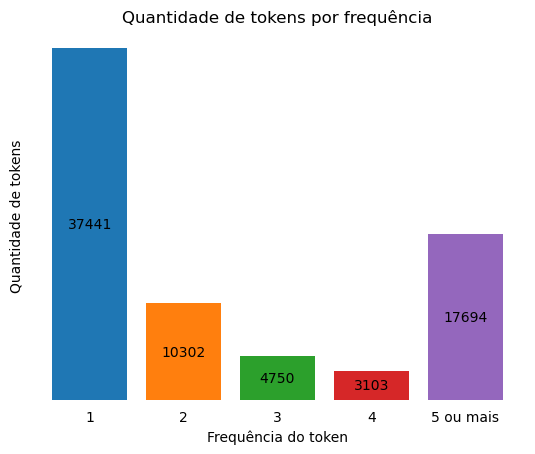

In [15]:
plot_tokens_freq(tokens_freq_basic_clean_docs)

### Vetores considerando todas as categorias

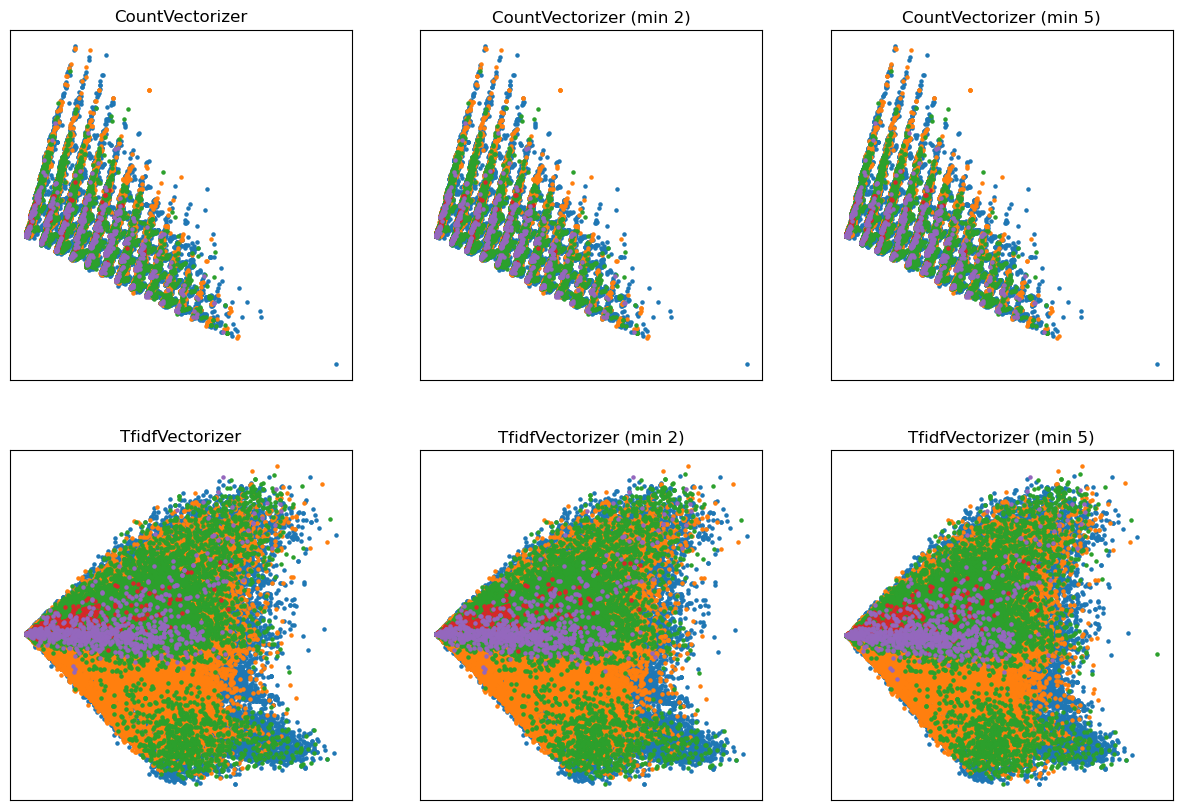

In [16]:
plot_doc_vectors(df_basic_clean_docs)

## Anúncios com categoria não nula

In [17]:
df_basic_clean_docs_not_null, tokens_freq_basic_clean_docs_not_null = get_basic_clean_docs(df_docs_not_null)
df_basic_clean_docs_not_null

  0%|          | 0/51376 [00:00<?, ?it/s]

,clean_docs,clean_tokens,cat_0
0,filtro de lente de efeitos especiais blue stre...,"[filtro, de, lente, de, efeitos, especiais, bl...",1
1,"motores sem escova , 4 conjuntos de motores se...","[motores, sem, escova, ,, 4, conjuntos, de, mo...",1
2,"bolsa de armazenamento protetora para drone , ...","[bolsa, de, armazenamento, protetora, para, dr...",4
3,equss para ducati dl650 dl1000 v-strom dl 650 ...,"[equss, para, ducati, dl650, dl1000, v-strom, ...",1
4,"remote control car brushless motor servo kit ,...","[remote, control, car, brushless, motor, servo...",1
...,...,...,...
51371,"mini drone de bolso , hd folding fotografia ae...","[mini, drone, de, bolso, ,, hd, folding, fotog...",1
51372,"yitre mini carregador portatil , 2 em 1 carreg...","[yitre, mini, carregador, portatil, ,, 2, em, ...",1
51373,"kit de reforco de sinal , kit de reforco de si...","[kit, de, reforco, de, sinal, ,, kit, de, refo...",2
51374,hosioe ls-xt6 rc drone mini drone 6 eixos gyro...,"[hosioe, ls-xt6, rc, drone, mini, drone, 6, ei...",1


### Tokens

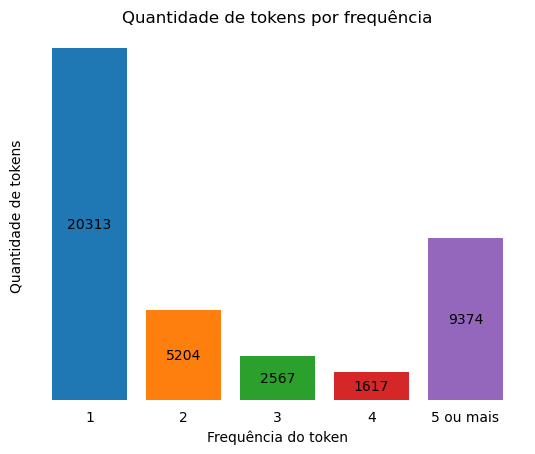

In [18]:
plot_tokens_freq(tokens_freq_basic_clean_docs_not_null)

### Vetores considerando todas as categorias (não nulas)

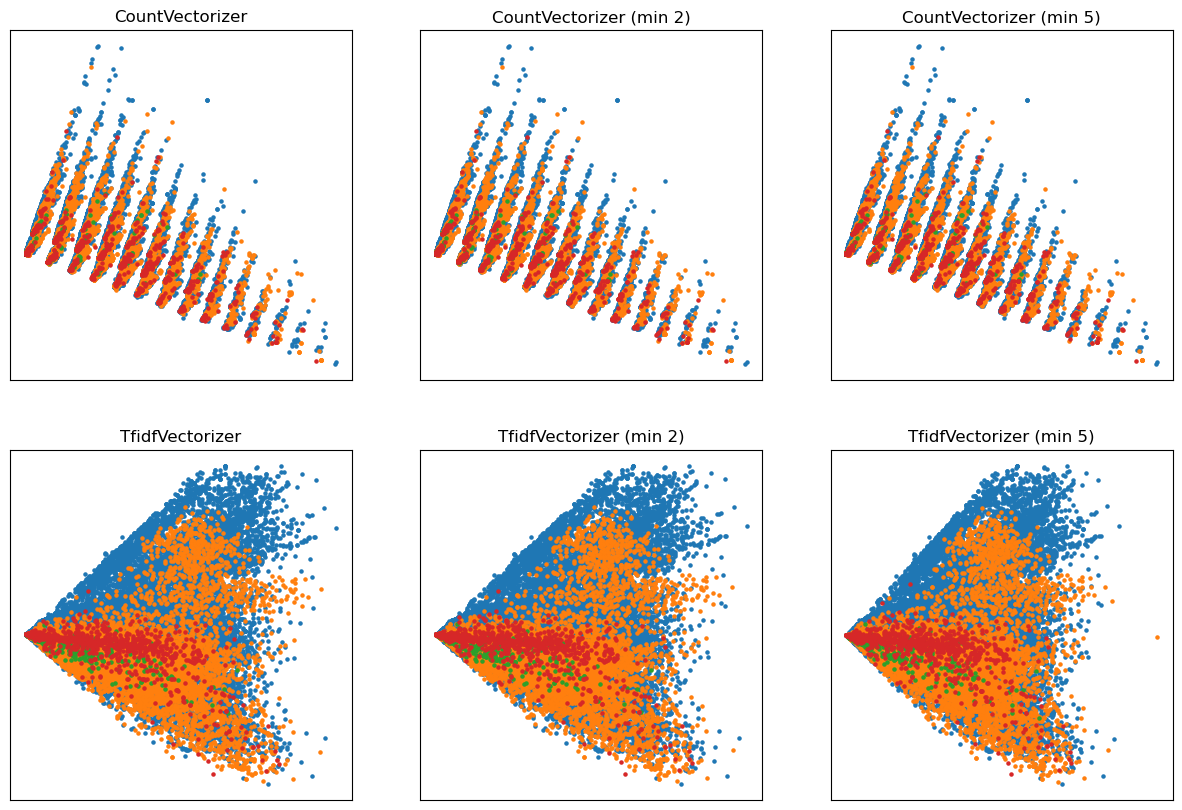

In [19]:
plot_doc_vectors(df_basic_clean_docs_not_null)

### Vetores considerando duas categorias: mais frequente e outras

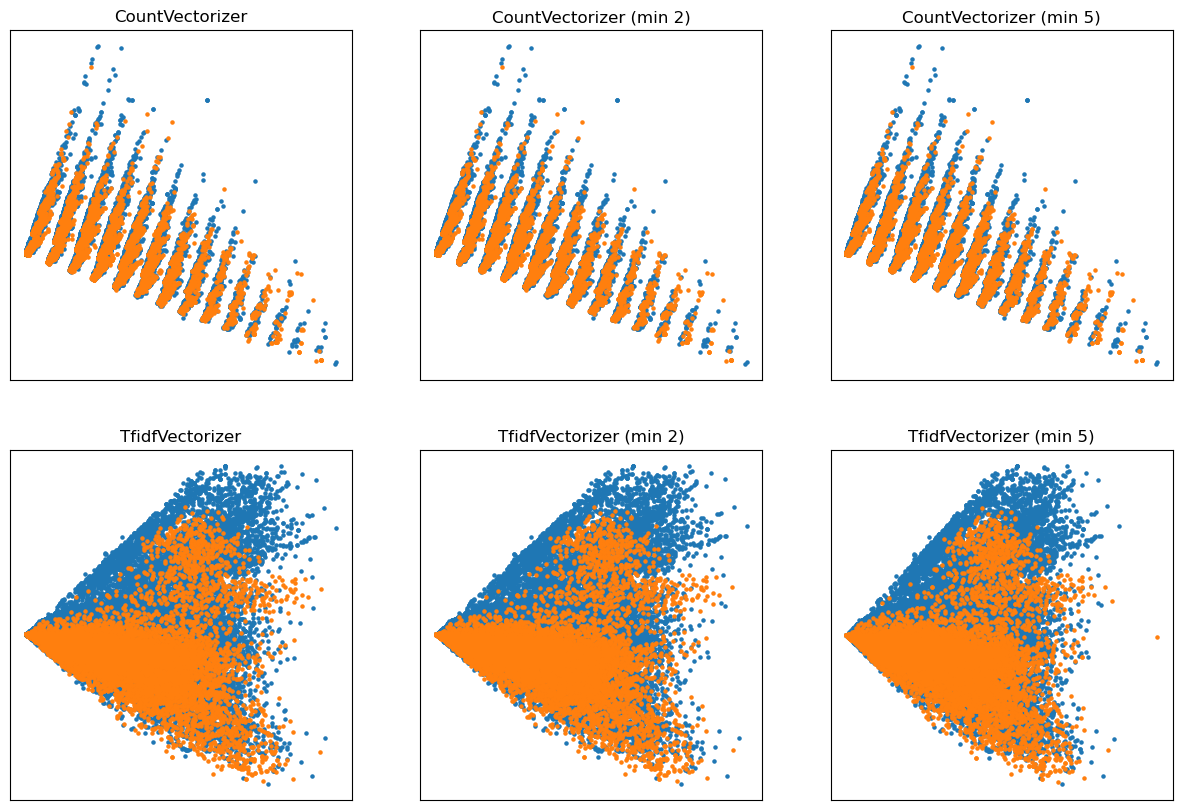

In [20]:
plot_doc_vectors(df_basic_clean_docs_not_null, True)

## Anúncios com categoria não nula, sem palavras frequentes e sem pontuação

In [21]:
df_clean_docs_not_null, tokens_freq_clean_docs_not_null = get_basic_clean_docs(df_docs_not_null)
df_clean_docs_not_null

  0%|          | 0/51376 [00:00<?, ?it/s]

,clean_docs,clean_tokens,cat_0
0,filtro de lente de efeitos especiais blue stre...,"[filtro, de, lente, de, efeitos, especiais, bl...",1
1,"motores sem escova , 4 conjuntos de motores se...","[motores, sem, escova, ,, 4, conjuntos, de, mo...",1
2,"bolsa de armazenamento protetora para drone , ...","[bolsa, de, armazenamento, protetora, para, dr...",4
3,equss para ducati dl650 dl1000 v-strom dl 650 ...,"[equss, para, ducati, dl650, dl1000, v-strom, ...",1
4,"remote control car brushless motor servo kit ,...","[remote, control, car, brushless, motor, servo...",1
...,...,...,...
51371,"mini drone de bolso , hd folding fotografia ae...","[mini, drone, de, bolso, ,, hd, folding, fotog...",1
51372,"yitre mini carregador portatil , 2 em 1 carreg...","[yitre, mini, carregador, portatil, ,, 2, em, ...",1
51373,"kit de reforco de sinal , kit de reforco de si...","[kit, de, reforco, de, sinal, ,, kit, de, refo...",2
51374,hosioe ls-xt6 rc drone mini drone 6 eixos gyro...,"[hosioe, ls-xt6, rc, drone, mini, drone, 6, ei...",1


### Tokens

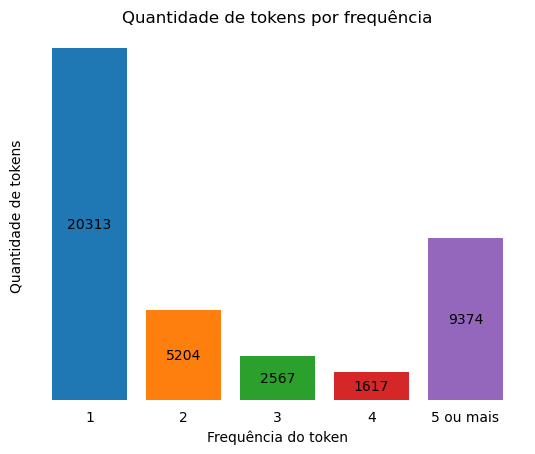

In [22]:
plot_tokens_freq(tokens_freq_clean_docs_not_null)

### Vetores considerando todas as categorias

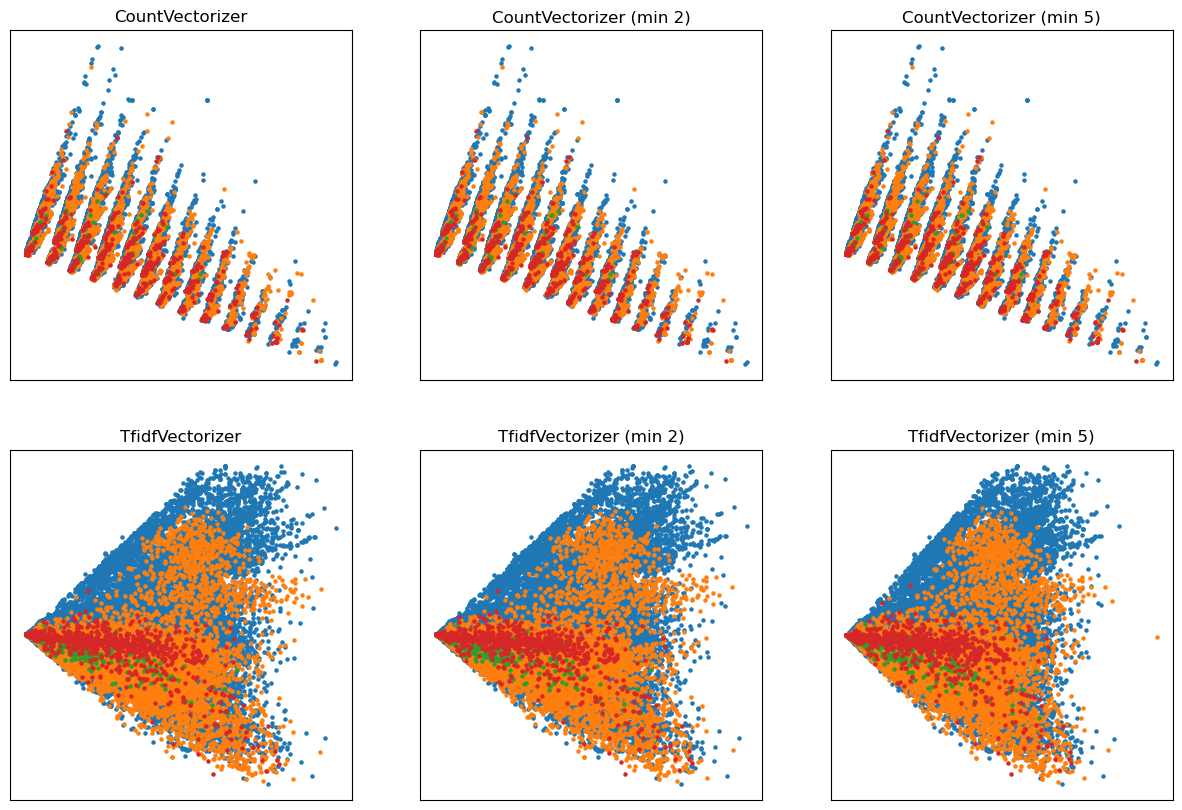

In [23]:
plot_doc_vectors(df_clean_docs_not_null,s=5)

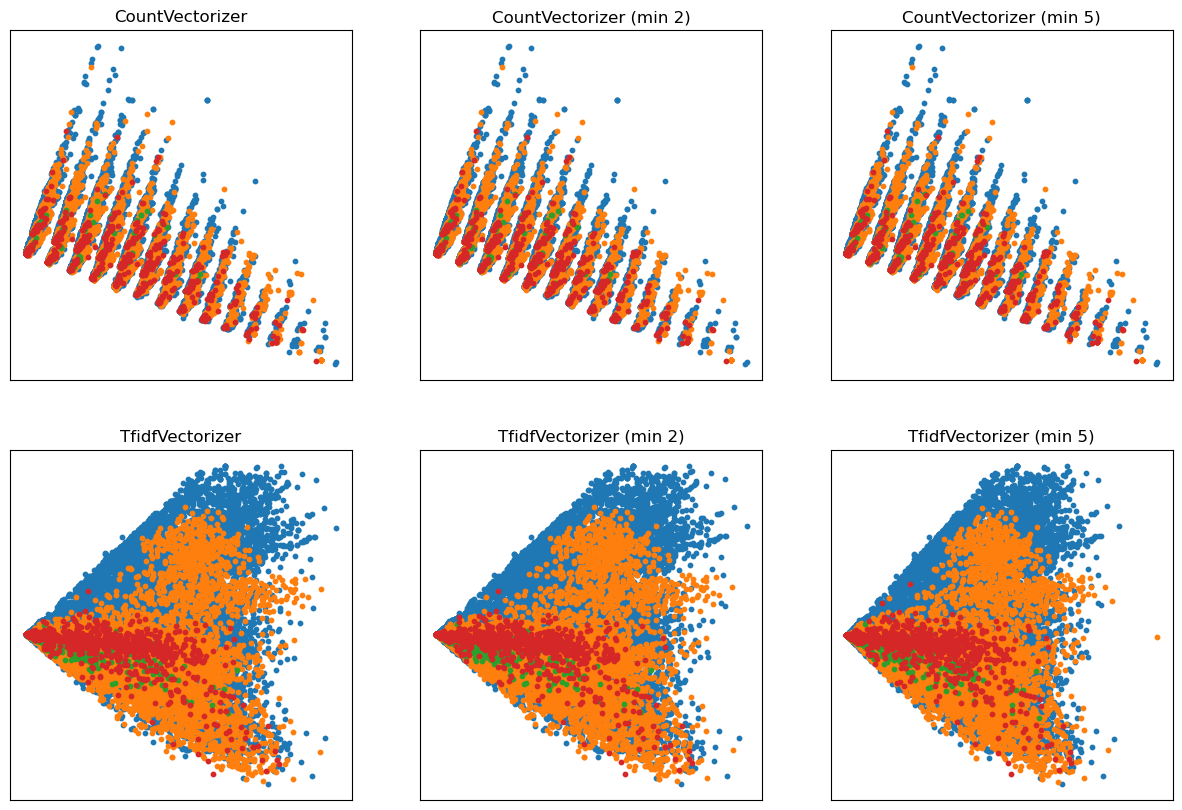

In [24]:
plot_doc_vectors(df_clean_docs_not_null,s=10)

### Vetores considerando todas duas categorias mais frequente e outras

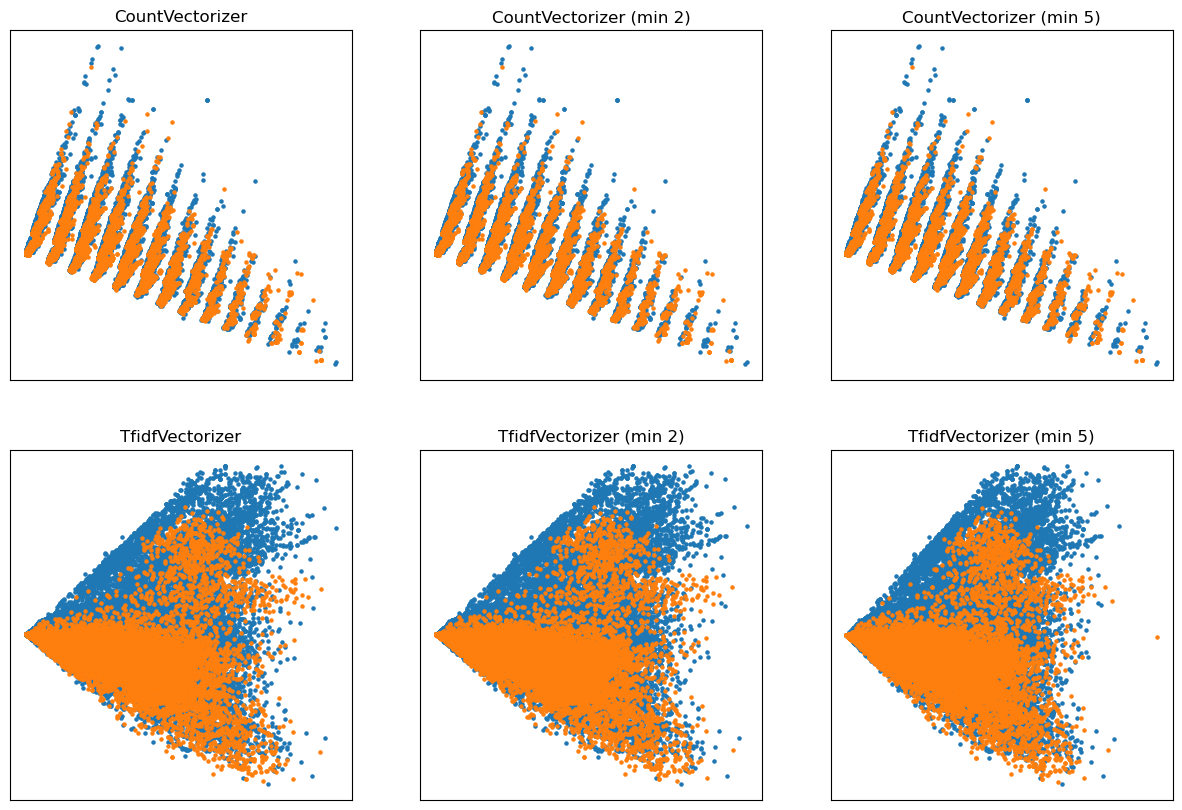

In [25]:
plot_doc_vectors(df_clean_docs_not_null,True)